In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-add-remove-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
1477,60,addremove,128000,0.1,0.0,zipf,0,8,mpi_priority_frontier,32.0,60.0,32,23990,0,57890,0,23253
1232,181,add,212000,0.1,0.5,zipf,0,6,mpi_no_master_frontier,32.0,60.0,32,589338,0,44227,0,21200
1830,148,add,184000,0.5,0.5,zipf,0,4,mpi_no_master_frontier,3.0,60.0,3,39958,0,9020596,0,92000
325,3,add,100000,0.2,0.0,zipf,0,1,mpi_no_master_frontier,32.0,60.0,32,276644,0,35415,0,20000
76,226,add,240000,0.1,0.5,zipf,0,5,mpi_no_master_frontier,32.0,60.0,32,83326,0,51593,0,24000


In [4]:
def prepare_plot_data(filter_cb, index):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

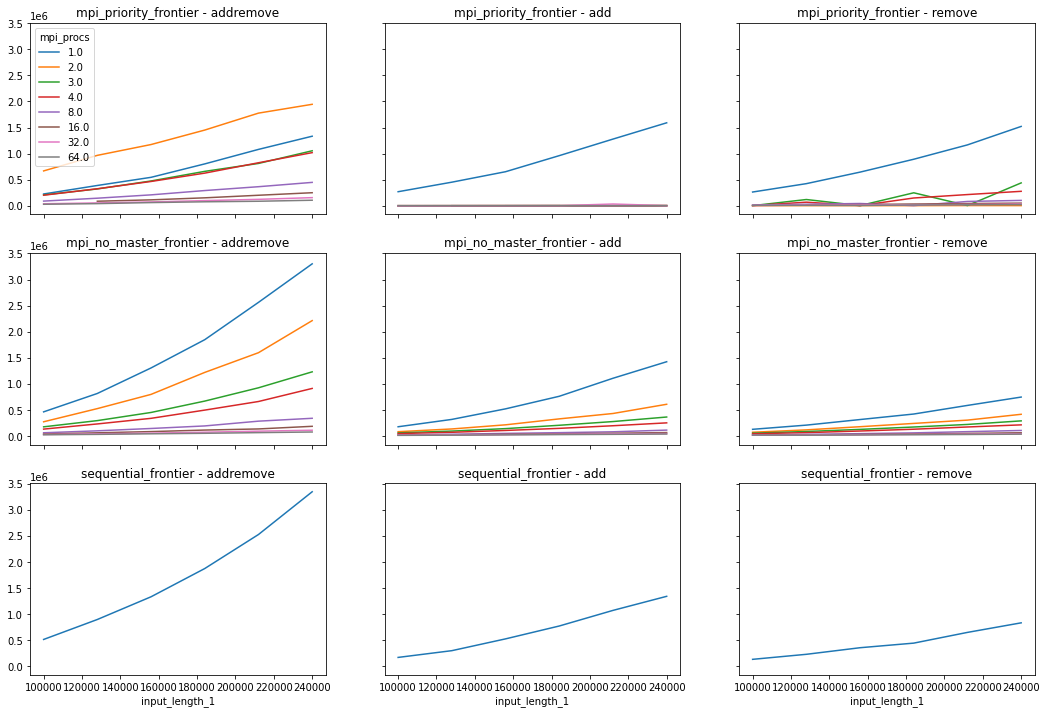

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

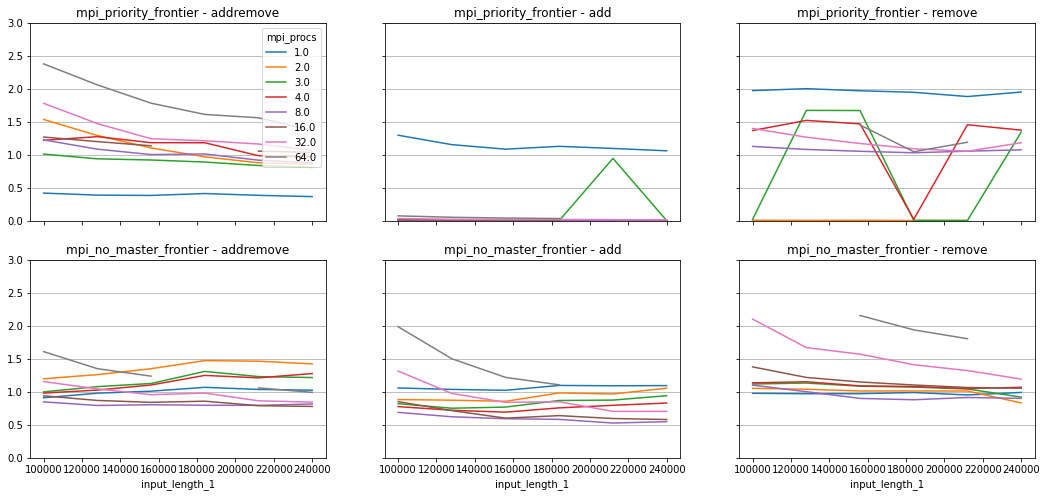

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == 0.2) & (temp['input_chunkiness'] == 0)]
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs('sequential_frontier', level='diff_program').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 3), grid=True);
        ax[diff_program_i][input_strategy_i].grid(axis='x')

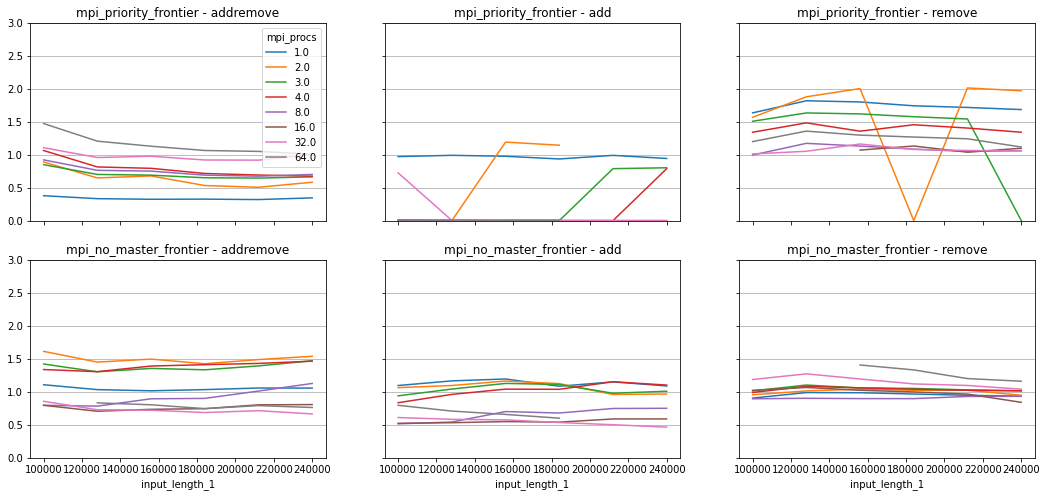

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == 0)]
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs('sequential_frontier', level='diff_program').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 3));
        ax[diff_program_i][input_strategy_i].grid(axis='y')